# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!



---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

Invalid requirement: './python'
It looks like a path. File './python' does not exist.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
from collections import namedtuple, deque

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='./Tennis.app')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# environment information
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
n_agents = len(env_info.agents)
print('Number of agents:', n_agents)

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like: ', states[0])

Number of agents: 2
Number of actions: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like:  [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


Episode: 	440 	Score: 	1.80 	Max Score: 	2.60 	Average Score: 	0.51
Environment solved in 440 episodes!	Average Score: 0.51


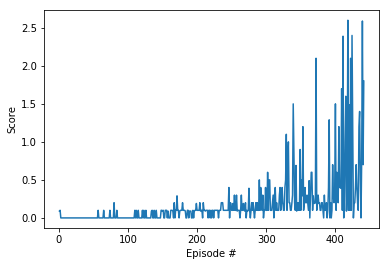

In [6]:
from train import Actor, Critic, ReplayBuffer, OUNoise

DEVICE = 'cpu'

# hyperparameters
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 2e-1              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 3e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

ADD_NOISE = True
SEED = 2

CHECKPOINT_FOLDER = './'

shared_memory = ReplayBuffer(DEVICE, action_size, BUFFER_SIZE, BATCH_SIZE, SEED)
noise = OUNoise(action_size, 2)

ACTOR_0_KEY = 0
ACTOR_1_KEY = 1

actor_0 = Actor(DEVICE, ACTOR_0_KEY, state_size, action_size, SEED, shared_memory, noise, LR_ACTOR, WEIGHT_DECAY, CHECKPOINT_FOLDER)
actor_1 = Actor(DEVICE, ACTOR_1_KEY, state_size, action_size, SEED, shared_memory, noise, LR_ACTOR, WEIGHT_DECAY, CHECKPOINT_FOLDER)
critic = Critic(DEVICE, state_size, action_size, SEED, GAMMA, TAU, LR_CRITIC, WEIGHT_DECAY, CHECKPOINT_FOLDER)

def maddpg_train():
    scores = []
    scores_window = deque(maxlen=100)
    n_episodes = 3000

    for episode in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]            # reset the environment
        states = env_info.vector_observations                        # get initial states
        actor_0.reset()                                              # reset the agent noise
        actor_1.reset()                                              # reset the agent noise
                                              
        score = np.zeros(n_agents)
        
        while True:
            action_0 = actor_0.act( states[ACTOR_0_KEY], ADD_NOISE )
            action_1 = actor_1.act( states[ACTOR_1_KEY], ADD_NOISE )
            actions = np.concatenate( (action_0, action_1) )
        
            env_info = env.step( actions  )[brain_name]              # send the action to the environment                            
            next_states = env_info.vector_observations               # get the next state        
            rewards = env_info.rewards                               # get the reward        
            dones = env_info.local_done                              # see if episode has finished        

            actor_0.step(states[ACTOR_0_KEY], action_0, rewards[ACTOR_0_KEY], next_states[ACTOR_0_KEY], dones[ACTOR_0_KEY])
            actor_1.step(states[ACTOR_1_KEY], action_1, rewards[ACTOR_1_KEY], next_states[ACTOR_1_KEY], dones[ACTOR_1_KEY])
            
            critic.step(actor_0, shared_memory)
            critic.step(actor_1, shared_memory)

            score += rewards                                         # update the score
        
            states = next_states                                     # roll over the state to next time step        
                                                        
            if np.any( dones ):                                      # exit loop if episode finished        
                break                                        

        actor_0.checkpoint()
        actor_1.checkpoint()
        critic.checkpoint()

        scores.append(np.max(score))
        scores_window.append(np.max(score))
        
        print('\rEpisode: \t{} \tScore: \t{:.2f} \tMax Score: \t{:.2f} \tAverage Score: \t{:.2f}'.format(episode, np.max(score), np.max(scores), np.mean(scores_window)), end="")  
        
        if np.mean(scores_window) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
            break    

    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()    


# train the agent
maddpg_train()

In [7]:
# test the trained agents
for episode in range(3):
    env_info = env.reset(train_mode=False)[brain_name]           # reset the environment
    states = env_info.vector_observations                        # get initial states
    score = np.zeros(n_agents)
    
    while True:
        action_0 = actor_0.act(states[ACTOR_0_KEY], add_noise=False)
        action_1 = actor_1.act(states[ACTOR_1_KEY], add_noise=False)
        actions = np.concatenate((action_0, action_1))
        
        env_info = env.step( actions )[brain_name]               # send the action to the environment                            
        next_states = env_info.vector_observations               # get the next state        
        rewards = env_info.rewards                               # get the reward        
        dones = env_info.local_done                              # see if episode has finished        
        
        score += rewards

        states = next_states

        if np.any(dones):                              
            break

    print('Episode: \t{} \tScore: \t{:.2f}'.format(episode, np.max(score)))  

Episode: 	0 	Score: 	2.60
Episode: 	1 	Score: 	2.70
Episode: 	2 	Score: 	2.70


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

When finished, you can close the environment.

In [8]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 